In [25]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [518]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
import sys
sys.path.append("/Users/markov/Dropbox/Research/OnGoing_Research/Snapshot/Python_experiment/source") 
import Discrete_Doucet_system
reload(Discrete_Doucet_system)

<module 'Discrete_Doucet_system' from '/Users/markov/Dropbox/Research/OnGoing_Research/Snapshot/Python_experiment/source/Discrete_Doucet_system.py'>

In [446]:
dsystem = Discrete_Doucet_system.Discrete_Doucet_system()
dsystem.theta, dsystem.sigma


(array([  0. ,   0.5,  25. ,   6. ,   0.2]), array([ 3.16227766,  2.23606798]))

In [447]:
init = -1.5
Nx0 = 30000

x0 = np.array([init]*Nx0 )
x0 = np.random.normal(init,  np.sqrt(5) , Nx0)

In [448]:
T0 = 4
xnow = x0
pnow = np.power(x0 - init,2)
xmean = np.array([0.]*(T0+1))
xmean2 = np.array([0.]*(T0+1))

xmean[0] = np.mean(x0)
xmean2[0] = np.mean(x0)


for t  in range(1,T0+1,1):
    xnow, pnow = dsystem.update(xnow, pnow)
    xmean[t] = np.mean(xnow)
    xmean2[t] = np.mean(np.power(xnow,2))

    
simul  = Discrete_Doucet_system.Simulate(T = T0) 
powers = [1,2,3]
mmts = simul.moment_history(dsystem, powers, Nx = Nx0)

xnow

array([ -5.31927381, -11.16765109,   2.32197654, ..., -15.95562851,
        -6.76837404,  -6.32503315])

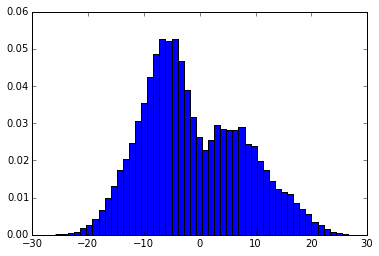

In [449]:
xplot= plt.hist(xnow,bins=50, normed=True)

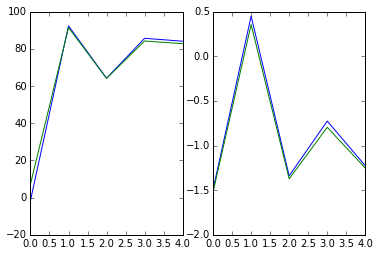

In [450]:
plt.subplot(1,2,0)
plt.plot(range(0,T0+1,1), xmean)
plt.plot(range(0,T0+1,1), mmts[0])
plt.subplot(1,2,1)
plt.plot(range(0,T0+1,1), xmean2)
plt.plot(range(0,T0+1,1), mmts[1])


In [451]:
mmts, xmean

(array([[ -1.51859462e+00,   3.55168768e-01,  -1.37289777e+00,
          -7.95895243e-01,  -1.25232471e+00],
        [  7.30868225e+00,   9.13986284e+01,   6.40950594e+01,
           8.41907227e+01,   8.27460543e+01],
        [ -2.59280270e+01,   9.41627089e+02,   1.11126491e+02,
           2.07794275e+02,  -8.00747529e+00]]),
 array([-1.49182793,  0.4489935 , -1.33928205, -0.72655177, -1.22543681]))

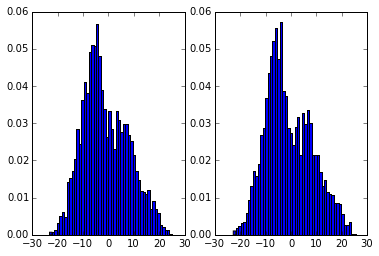

In [660]:
Nx_obs = 3000
Nx_dat = 3000
xobs = simul.simulate(dsystem, Nx = Nx_obs)
xdat = simul.simulate(dsystem, Nx = Nx_dat)
plt.subplot(1,2,0)
xplot= plt.hist(xobs[0],bins=50, normed=True)
plt.subplot(1,2,1)
xplot= plt.hist(xdat[0],bins=50, normed=True)

In [661]:
xdatmat = np.matrix([list(xdat[0])] * Nx_obs)
xobsmat = np.matrix([list(xobs[0])] * Nx_dat)
xdatmat.shape, xobsmat.shape

((3000, 3000), (3000, 3000))

In [662]:
diff = np.abs(xdatmat -np.transpose(xobsmat))
diffsqr = np.power(diff, 2)

In [663]:
diffsqr.shape

(3000, 3000)

In [664]:
#THIS is being done to increase the precision of the exponentiation  
pyx = np.exp(-(diffsqr  - np.transpose(np.matrix([[np.min(row) for row in diffsqr]]*Nx_dat))))


pyxm = np.matrix([row/np.sum(row) for row in pyx.tolist()])
px_new = np.array(np.sum(pyxm, 0))[0] 
px_new = px_new / sum(px_new)

In [665]:
Nx_resample = 5000
sample = np.random.multinomial(Nx_resample, px_new)

In [666]:
np.mean(px_new), np.var(px_new), np.mean(sample), np.var(sample), sum(sample)

(0.0003333333333333337,
 9.0886782833020983e-10,
 1.6666666666666667,
 1.6802222222222223,
 5000)

Based on observed Nx_obs values, the probability was  imposed on the set of paths of size Nx_dat. 
We can then resample paths from the computed probability.   The size of resampled set in below is 
Nx_resample.

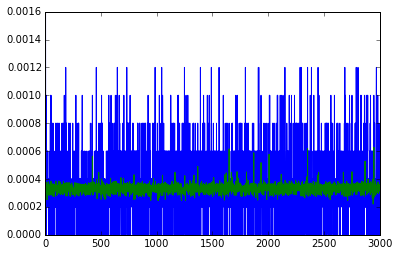

In [667]:
plt.plot(range(0, Nx_dat,1),np.double(sample)/Nx_resample)
plt.plot(range(0, Nx_dat,1),px_new)

Larger number of resampling gives.... 

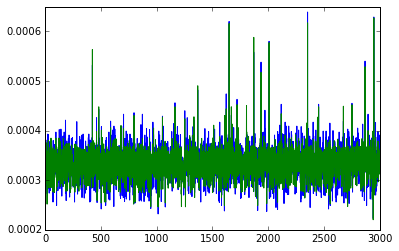

In [668]:
Nx_resample2 = 1000000
sample = np.random.multinomial(Nx_resample2, px_new)
plt.plot(range(0, Nx_dat,1),np.double(sample)/Nx_resample2)
plt.plot(range(0, Nx_dat,1),px_new)

The ordered version of the probability over paths(?) 

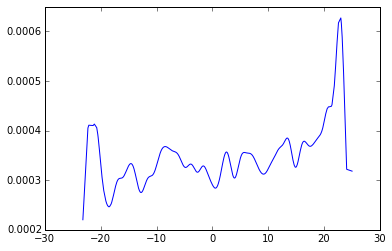

In [669]:
xdat_ordered = np.sort(xdat[0])
px_new_ordered = px_new[np.argsort(xdat[0])]

plt.plot(xdat_ordered, px_new_ordered)

As obvious as it may be,  I do not really need to do the resampling.  I can use the computed $px_new$ directly.
We merely need to do the maximization ofthe expectation of : 

$$ \textrm{Dir} \left( \alpha H(\theta_{old}) + \sum_i  p_{x_i}(\{ x_{obs} \} ) \delta_{x_i}    \right)  $$ 

Still yet, I cannot take the derivative of the expecation with respect to $\alpha H(\theta_{old}) $
so I DO need to take sample from $H(\theta_{old})$ and impose an appropriate weight. 

I need 
(1) p_{x_i}(\{ x_{obs} \})
(2) sum of beta_i and  A_i over all paths (From re-weighted previous AND new) 
I NEED to STORE the sum of A and sum of B for all simulations. 

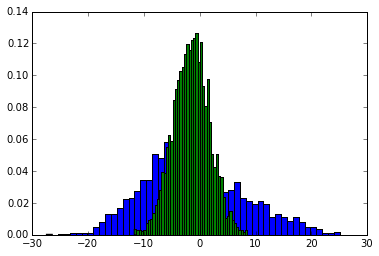

In [670]:
theta_approx = np.array([-1.5, 0., 0., 0., 0.])
dsystem_approx = Discrete_Doucet_system.Discrete_Doucet_system(theta= theta_approx)

Nx_obs = 3000
Nx_dat = 3000
xobs,pobs = simul.simulate(dsystem, Nx = Nx_obs)
xdat, pdat= simul.simulate(dsystem_approx, Nx = Nx_dat)
xplot= plt.hist(xobs,bins=50, normed=True)
xplot= plt.hist(xdat,bins=50, normed=True)


xdatmat = np.matrix([list(xdat)] * Nx_obs)
xobsmat = np.matrix([list(xobs)] * Nx_dat)
xdatmat.shape, xobsmat.shape
diff = np.abs(xdatmat -np.transpose(xobsmat))
diffsqr = np.power(diff, 2)


pyx = np.exp(-(diffsqr  - np.transpose(np.matrix([[np.min(row) for row in diffsqr]]*Nx_dat))))


pyxm = np.matrix([row/np.sum(row) for row in pyx.tolist()])
px_new = np.array(np.sum(pyxm, 0))[0] 
px_new = px_new / sum(px_new)



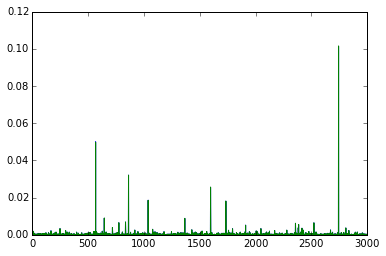

In [671]:
Nx_resample2 = 1000000
sample = np.random.multinomial(Nx_resample2, px_new)
plt.plot(range(0, Nx_dat,1),np.double(sample)/Nx_resample2)
plt.plot(range(0, Nx_dat,1),px_new)

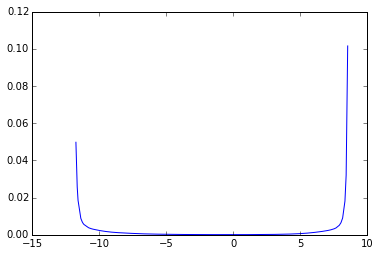

In [672]:
xdat_ordered = np.sort(xdat)
px_new_ordered = px_new[np.argsort(xdat)]

plt.plot(xdat_ordered, px_new_ordered)

Let's check that the formula itself is correct and yields approximately same answer when starting with the correct parameters: 

In [673]:
(np.array(dsystem.jacob(xdat))* np.array(xdat)).sum(axis = 1) 

array([ -4706.55827516,  39011.21326157,   2145.77854859,  -2017.90250795])

In [674]:
ffih = np.array(range(0,9)).reshape([3,3])
xx  = (np.array(range(0,3))*10).reshape([1,3])
ffih, xx, type(xx), type(ffih)

(array([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]]), array([[ 0, 10, 20]]), numpy.ndarray, numpy.ndarray)

In [675]:
ffih * xx

array([[  0,  10,  40],
       [  0,  40, 100],
       [  0,  70, 160]])

In [775]:
ffih * xx.transpose()

array([[  0,   0,   0],
       [ 30,  40,  50],
       [120, 140, 160]])

In [779]:
reload(Discrete_Doucet_system)
simul  = Discrete_Doucet_system.Simulate(T = T0) 

dsystem = Discrete_Doucet_system.Discrete_Doucet_system()


In [780]:
xdat, pdat, A, B = simul.simulate(dsystem, 50000, stat= True)
type(xdat), type(pdat), type(A), type(B)

(numpy.ndarray, numpy.ndarray, numpy.matrixlib.defmatrix.matrix, numpy.ndarray)

In [781]:
np.linalg.inv(A) * np.matrix(B).transpose()

matrix([[ -2.52855608e-04],
        [  5.00225873e-01],
        [  2.50122799e+01],
        [  6.00207190e+00]])

In [764]:
dsystem.jacob(xdat).shape

(4, 50000)

In [711]:
xobs,pobs = simul.simulate(dsystem, Nx = 1000)
xdat,pdat = simul.simulate(dsystem, Nx = 3000)

dsystem.jacob(xobs).shape, dsystem.jacob(xdat).shape

((4, 1000), (4, 3000))

In [712]:
px = dsystem.compare(xdat, xobs) 

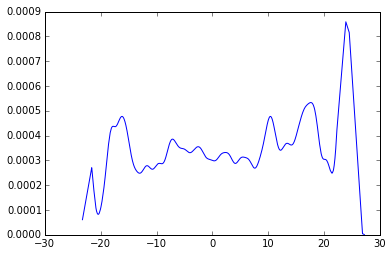

In [713]:
xdat_ordered = np.sort(xdat)
px_new_ordered = px[np.argsort(xdat)]

plt.plot(xdat_ordered, px_new_ordered)

In [717]:
px.shape,    dsystem.jacob(xdat).shape,  type(px),  type(dsystem.jacob(xdat))

((3000,), (4, 3000), numpy.ndarray, numpy.matrixlib.defmatrix.matrix)

In [718]:
np.array(dsystem.jacob(xdat)) * px

array([[  3.10260819e-04,   3.05915235e-04,   2.73499221e-04, ...,
          3.45752761e-04,   3.49305570e-04,   2.87866250e-04],
       [ -3.31142234e-04,   1.96039884e-03,   1.99494550e-03, ...,
         -1.74634179e-03,  -1.98413983e-03,  -2.76912074e-03],
       [ -1.54801918e-04,   4.66024836e-05,   3.68039305e-05, ...,
         -6.58723911e-05,  -5.96462225e-05,  -2.96054349e-05],
       [  3.03219038e-04,   8.72235021e-05,   3.05585293e-05, ...,
          1.83843135e-04,   1.47121207e-04,  -9.95458825e-05]])

In [807]:
reload(Discrete_Doucet_system)
dsystem = Discrete_Doucet_system.Discrete_Doucet_system()
simul  = Discrete_Doucet_system.Simulate(T = T0) 
xdat, pdat, A, B = simul.simulate(dsystem, 10000, stat= True)
type(xdat), type(pdat), type(A), type(B)

(numpy.ndarray, numpy.ndarray, numpy.matrixlib.defmatrix.matrix, numpy.ndarray)

In [808]:
xdat.shape, dsystem.jacob(xdat).shape

((10000,), (4, 10000))

In [809]:
k =1
Adashp= np.zeros([len(xdat), R,R])
for k in range(0, len(xdat)):
    Adashp[k] = dsystem.jacob(xdat)[:,k] *  dsystem.jacob(xdat)[:,k].transpose()


In [811]:
Adashp.shape

(10000, 4, 4)

In [812]:
dsystem.jacob(xdat).shape

(4, 10000)

In [815]:
test = np.random.normal(0,1,[2,5])

In [816]:
test

array([[-0.94044165,  0.67042762, -1.02061765, -0.29216306, -0.05932108],
       [-0.14430874,  1.50306566,  0.98028087,  1.26324835,  0.06157547]])

In [817]:
test1 = transpotest.reshape([5,2,1])
test2 = test.reshape([5,1,2])

In [818]:
test1

array([[[-0.94044165],
        [ 0.67042762]],

       [[-1.02061765],
        [-0.29216306]],

       [[-0.05932108],
        [-0.14430874]],

       [[ 1.50306566],
        [ 0.98028087]],

       [[ 1.26324835],
        [ 0.06157547]]])